In [1]:
import pandas as pd
import numpy as np
import torch
import sys

import gym
from gym import spaces
from gym.spaces import Tuple, Discrete

import talib

sys.path.append("..") 
from data_provider import read_data
from tensorboardX import SummaryWriter

In [5]:
#Position sizing
max_action = 2
class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human', 'file', 'none']}

    def __init__(self, data, lead_window, lag_window):
        super(TradingEnv, self).__init__()
        
        self.prices = data['C'].values
        self.initial_balance = 10000
        self.net_worth = self.initial_balance
        self.commission = 0.00075
        self.contract = 10
        self.open_action = 0
        self.open_position = 0
        self.profit = 0  
        self.offset = lag_window
        
        self.fast = talib.MA(self.prices, lead_window)
        self.slow = talib.MA(self.prices, lag_window)
        
        ma_quant = 20
        ma_diff =  self.fast - self.slow
        ma_diff[:self.offset] = 0
        ma_bins = np.quantile(ma_diff[self.offset:],np.arange(ma_quant)/ma_quant)
        self.ma_states = np.digitize(ma_diff, ma_bins)
        
        volumes = data['V'].values
        vol_quant = 20
        vol_bins = np.quantile(volumes, np.arange(vol_quant)/vol_quant)
        self.vol_states = np.digitize(volumes, vol_bins)

        self.action_space = spaces.Discrete(5)
        self.observation_space = Tuple([Discrete(ma_quant), Discrete(vol_quant), Discrete(2)])   

    def _next_observation(self):
        obs = (self.ma_states[self.current_step], self.vol_states[self.current_step], int(self.shares_held/self.contract))
        return obs

    def reset(self):
        self.current_step = self.offset
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0.0
        self.trades = 0
        return self._next_observation()
    
    def _take_action(self, action):  
        current_price = self.prices[self.current_step]        
        
        if action > 0 and self.open_action < max_action:
            action_to_buy = min(max_action - self.open_action, action)
            price = current_price * buy_correction
            shares_to_buy = self.contract * action_to_buy 
            self.shares_held += shares_to_buy 
            cost =  shares_to_buy * price * (1 + self.commission)
            self.balance = self.balance - cost
            self.open_position = self.open_position + cost 
            self.open_action = self.open_action + action_to_buy
            
        elif action < 0 and self.open_action > 0:
            action_to_sell = min(self.open_action, -action)
            price = current_price * sell_correction
            shares_to_sell = self.contract * action_to_sell 
            cash = shares_to_sell * price *(1 - self.commission) 
            
            self.balance = self.balance + cash
            share_cost = self.open_position/self.shares_held
            self.profit = cash -  share_cost * shares_to_sell
            self.shares_held = self.shares_held - self.contract*action_to_sell
            self.open_position =  share_cost * self.shares_held
            self.open_action = self.open_action - action_to_sell 
            self.trades = self.trades + 1
            
        new_net = self.balance + self.shares_held * current_price * (1 - self.commission) * sell_correction
        self.net_diff = new_net - self.net_worth 
        self.net_worth = new_net

        
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action - max_action)
        self.current_step += 1

        #delay_modifier = (self.current_step / MAX_STEPS)
        #reward = self.balance * delay_modifier + self.current_step
 
        reward = self.net_diff
#        reward = self.profit
#        self.profit = 0
        done = self.net_worth <= 0 or self.current_step >= len(self.prices) - 1
        
        obs = self._next_observation()
        return obs, reward, done, {}     
    

In [38]:
class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human', 'file', 'none']}

    def __init__(self, data, lead_window, lag_window):
        super(TradingEnv, self).__init__()
        
        self.prices = data['C'].values
        self.initial_balance = 10000
        self.net_worth = self.initial_balance
        self.commission = 0.00075
        self.contract = 10
        self.open_position = 0
        self.profit = 0  
        self.offset = lag_window
        
        self.fast = talib.MA(self.prices, lead_window)
        self.slow = talib.MA(self.prices, lag_window)
        
        ma_quant = 10
        ma_diff =  self.fast - self.slow
        ma_diff[:self.offset] = 0
        ma_bins = np.quantile(ma_diff[self.offset:],np.arange(ma_quant)/ma_quant)
        self.ma_states = np.digitize(ma_diff, ma_bins)
        
        volumes = data['V'].values
        vol_quant = 10
        vol_bins = np.quantile(volumes, np.arange(vol_quant)/vol_quant)
        self.vol_states = np.digitize(volumes, vol_bins)

        self.action_space = spaces.Discrete(3)
        self.observation_space = Tuple([Discrete(ma_quant), Discrete(vol_quant), Discrete(2)])   

    def _next_observation(self):
        obs = (self.ma_states[self.current_step], self.vol_states[self.current_step], int(self.shares_held/self.contract))
        return obs

    def reset(self):
        self.current_step = self.offset
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0.0
        self.trades = 0
        return self._next_observation()
    
    def _take_action(self, action):  
        current_price = self.prices[self.current_step]        
        
        if action == 1 and self.shares_held== 0 :
            price = current_price * buy_correction
            self.shares_held += self.contract
            cost =  self.contract * price * (1 + self.commission)
            self.balance = self.balance - cost
            self.open_position = self.open_position + cost 
            
        elif action == 2 and self.shares_held > 0:
            price = current_price * sell_correction
            cash = self.contract * price *(1 - self.commission) 
            self.balance = self.balance + cash
            self.profit = cash - self.open_position
            self.open_position =  0
            self.shares_held = 0
            self.trades = self.trades + 1
            
        new_net = self.balance + self.shares_held * current_price * (1 - self.commission) * sell_correction
        self.net_diff = new_net - self.net_worth 
        self.net_worth = new_net

        
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1

        #delay_modifier = (self.current_step / MAX_STEPS)
        #reward = self.balance * delay_modifier + self.current_step
 
        reward = self.net_diff
#        reward = self.profit
#        self.profit = 0
        done = self.net_worth <= 0 or self.current_step >= len(self.prices) - 1
        
        obs = self._next_observation()
        return obs, reward, done, {}     
    

In [39]:
#data = read_data('LINK-USDT', '30m', '2018-02-06')
data = read_data('BNB-USDT', '15m', '2020-03-15')
MAX_STEPS = data.shape[0]
train = round(MAX_STEPS * 0.7)
env = TradingEnv(data.iloc[:train], 78, 105)

buy_correction =  1.0001
sell_correction   = 0.9999

number_of_actions = env.action_space.n
env.reset()

(8, 10, 0)

In [40]:
import collections
num_episodes = 2500
Q = collections.defaultdict(list)
G = 0
alpha = 0.1
gamma = 1
epsilon = 0.7
epsilon_final = 0.02
epsilon_decay = 0.998
writer = SummaryWriter(comment="-trade_env_ma")

for episode in range(1, num_episodes):
    done = False
    G, reward = 0,0
    state = env.reset()
    while done != True:
        random_for_egreedy = np.random.rand()
        if random_for_egreedy > epsilon:    
            action = np.argmax(Q[state]) #1
        else:
            action = env.action_space.sample()
        new_state, reward, done, info = env.step(action) #2
        
        if len(Q[state]) == 0:
            Q[state] = np.zeros(number_of_actions)
        if len(Q[new_state]) == 0:
            Q[new_state] = np.zeros(number_of_actions)
            
        Q[state][action] = (1 - alpha)*Q[state][action] + alpha*(reward + gamma*np.max(Q[new_state])) #3
        G += reward
        state = new_state   
    writer.add_scalar("reward", G, episode) 
    writer.add_scalar("trades", env.trades, episode)      
    writer.add_scalar("shares", env.shares_held, episode)      
    if epsilon > epsilon_final:
        epsilon *= epsilon_decay

#    if episode % int(num_episodes/2) == 0:   
#        Q = Q - Q.mean(axis = 1, keepdims = 1)
        
    if episode % 20 == 0:
        print('Episode {} Total Reward: {}, epsilon: {}'.format(episode,  G, epsilon))
writer.close()

Episode 20 Total Reward: -207.35203543942407, epsilon: 0.6725256699184399
Episode 40 Total Reward: -229.17655725748773, epsilon: 0.6461296809989233
Episode 60 Total Reward: -179.21574194845562, epsilon: 0.620769709382841
Episode 80 Total Reward: -230.61848031048976, epsilon: 0.5964050923825294
Episode 100 Total Reward: -186.57217501928608, epsilon: 0.5729967632818997
Episode 120 Total Reward: -192.31161679924298, epsilon: 0.550507188696082
Episode 140 Total Reward: -204.97711155116303, epsilon: 0.528900308389642
Episode 160 Total Reward: -163.30803019156156, epsilon: 0.5081414774568763
Episode 180 Total Reward: -187.1650590872323, epsilon: 0.48819741077147377
Episode 200 Total Reward: -166.04788370759888, epsilon: 0.46903612961647606
Episode 220 Total Reward: -132.81513335581803, epsilon: 0.450626910408961
Episode 240 Total Reward: -130.30613635694317, epsilon: 0.4329402354372333
Episode 260 Total Reward: -148.56053304947272, epsilon: 0.41594774553153196
Episode 280 Total Reward: -144.

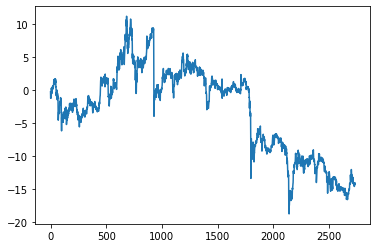

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

env_val = TradingEnv(data.iloc[train:], 78, 105)
state = env_val.reset()
profit = []
done = False
while done != True:
    if len(Q[state]) == 0:
        action = 0
    else:
        action = np.argmax(Q[state]) #1
    state, reward, done, info = env_val.step(action) #2

    profit.append(reward)

cum_profit = np.array(profit).cumsum()

plt.plot(cum_profit)
plt.show()

In [141]:
len(Q[state])

0

In [ ]:
#num_episodes = 3000
#Q = np.zeros([number_of_states, number_of_actions])
#G = 0
#alpha = 0.1
#gamma = 1
#epsilon = 0.7
#epsilon_final = 0.01
#epsilon_decay = 0.998

In [178]:
#Q - Q.mean(axis = 1)
from sklearn.preprocessing import scale
qs = scale(Q - Q.mean(axis = 1, keepdims = 1), axis =1).round(2)

df = pd.DataFrame(qs)
df.columns= ['hold', 'buy_1', 'sell_1', ]

#ind = np.round((env.bins + 1)*2).astype(int).tolist()
#df.index = ind
#df.apply(lambda x: df.columns[np.argmax(x)], axis =1)
df

AttributeError: 'collections.defaultdict' object has no attribute 'mean'

In [21]:
import collections
x = collections.defaultdict(float)
x[('a','b', 3)] = 3

## Simple Q-learning